In [150]:
import pandas as pd
from datetime import datetime

In [151]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('raw.csv', parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

In [152]:
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [153]:
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

In [154]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [155]:
dataset.to_csv("pollution.csv")

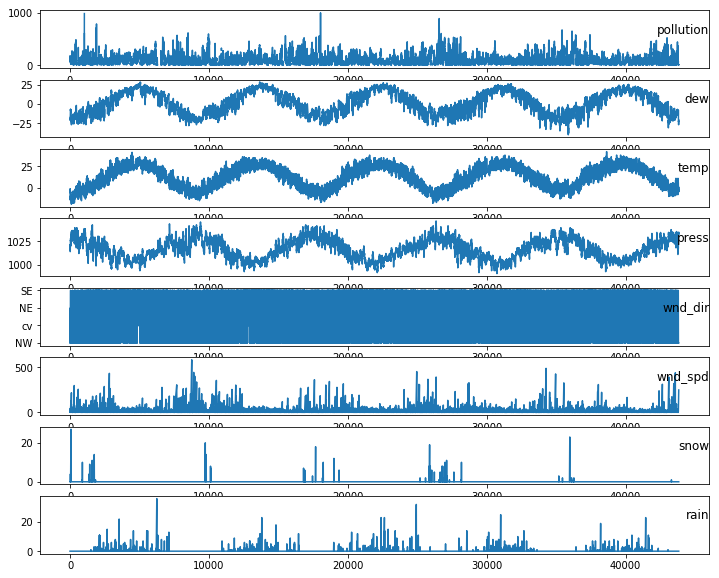

In [156]:
import matplotlib.pyplot as plt
dataset = pd.read_csv("pollution.csv", header=0, index_col=0)
values = dataset.values
groups = [0,1,2,3,4,5,6,7]
i = 1
plt.figure(figsize=(12,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [157]:
from pandas import DataFrame, concat
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg 

In [158]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
print(values.shape)
# print(values[0])
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print("After Sceling")
print(scaled.shape)
# print(scaled[0])
# print(scaled)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# print("Before droping Columns")
print(reframed.shape)
# # drop columns we don't want to predict
# print(reframed.head())
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
# print("After droping Columns")
print(reframed.shape)
# print(reframed.head())

(43824, 8)
After Sceling
(43824, 8)
(41543, 16)
(41543, 9)


In [159]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
print(test.shape)
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_y)

(32783, 9)
(8760, 8) (8760,) (32783, 8) (32783,)
[0.14889336 0.15995975 0.18209255 ... 0.04929577 0.04929577 0.05935613]


In [160]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

IndexError: tuple index out of range

In [161]:
from numpy import concatenate
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f') 
# # make predictions
# trainPredict = model.predict(train_X)
# print(trainPredict.shape)
# testPredict = model.predict(test_X)
# print(testPredict.shape)
# # trainPredict = trainPredict.reshape((trainPredict.shape[0], 1, trainPredict.shape[1]))
# # trainPredict.shape

IndexError: tuple index out of range

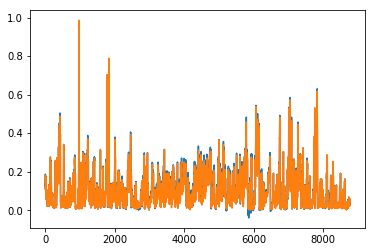

In [140]:
plt.plot(trainPredict)
plt.plot(train_y)

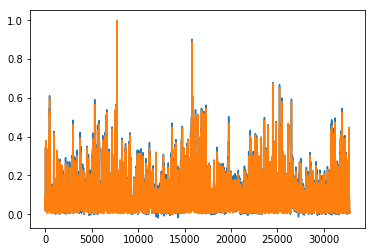

In [141]:
plt.plot(testPredict)
plt.plot(test_y)

In [145]:
print(trainPredict.dtype)
print(testPredict.dtype)

float32
float32


In [146]:
print(train_X.shape)
print(test_X.shape)

(8760, 1, 8)
(32783, 1, 8)
